# Contents
- [Data Exploration](#Data-Exploration)
- [Embedding Only](#Embedding-only)
- [Non-negative Matrix factorisation (NNMF)](#Non-negative-Matrix-factorisation-(NNMF))
- [Embedding & Neural Network](#Embedding-&-Neural-Network)
- [Adding Genre data to the network](#Adding-Genre-data-to-the-network)

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import SVG
import keras
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from math import sqrt

ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

ratings = pd.merge(ratings, movies, on='movieId')

# ratings = ratings.drop('genres', 1)
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values
print(ratings.head())

Using TensorFlow backend.


   userId  movieId  rating   timestamp             title  \
0       0        0     4.0   964982703  Toy Story (1995)   
1       4        0     4.0   847434962  Toy Story (1995)   
2       6        0     4.5  1106635946  Toy Story (1995)   
3      14        0     2.5  1510577970  Toy Story (1995)   
4      16        0     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


# Data Exploration 

Number of users: 610
Number of movies: 9724


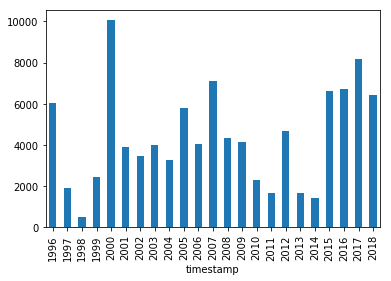

In [2]:
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique())

print("Number of users:",n_users)
print("Number of movies:",n_movies)

#Convert timestamps to dates
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

#plot timestamps frequencies
ratings["timestamp"].groupby(ratings["timestamp"].dt.year).count().plot(kind="bar",)

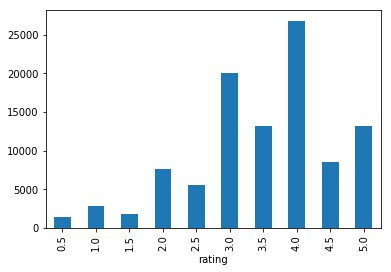

In [3]:
# Plot ratings frequencies
ratings['rating'].groupby(ratings['rating']).count().plot(kind='bar')

#split dataset based on date
#train = ratings[(ratings['timestamp'] < '2017-07-01') ]
#test = ratings[(ratings['timestamp'] >= '2017-07-01') ]
ratings = ratings.drop('timestamp', 1)

Dataset split

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.05)
print("Number of rows in test data set:", (len(test)))
print("Number of rows in training data set:",(len(train)))

Number of rows in test data set: 5042
Number of rows in training data set: 95794


# Embedding only

Instructions for updating:
Colocations handled automatically by placer.


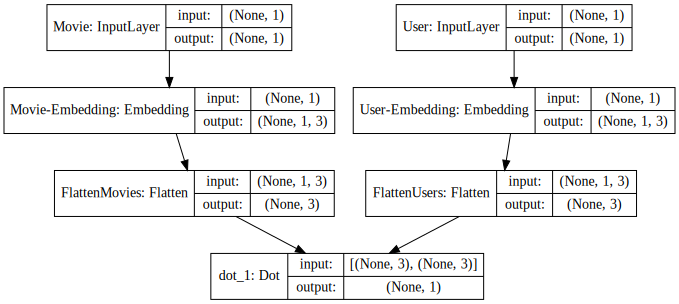

In [5]:
n_latent_factors = 3
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.dot([movie_vec,user_vec],axes=1)

model = keras.Model([user_input, movie_input], prod)
model.compile(optimizer=Adam(),loss= 'mean_squared_error')

#visualize model
SVG(model_to_dot(model,show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Instructions for updating:
Use tf.cast instead.


Text(0, 0.5, 'Train Error')

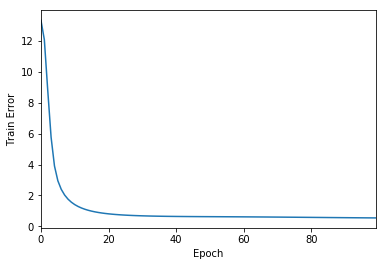

In [6]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [7]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating
print("MAE:",mean_absolute_error(y_true,y_hat))
print("RMSE:",sqrt(mean_squared_error(y_true, y_hat)))

MAE: 0.7537085470617503
RMSE: 1.065096930840333


# Non-negative Matrix factorisation (NNMF)
The only change we need in the above model is adding an additional parameter in the embeddings.

In [8]:
from keras.constraints import non_neg
n_latent_factors = 3
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.dot([movie_vec, user_vec], axes=1)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

Text(0, 0.5, 'Train Error')

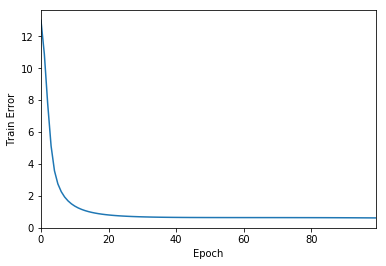

In [9]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [10]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating
print("MAE:",mean_absolute_error(y_true,y_hat))
print("RMSE:",sqrt(mean_squared_error(y_true, y_hat)))

MAE: 0.7486510128351738
RMSE: 1.0546762113721049


# Embedding & Neural Network

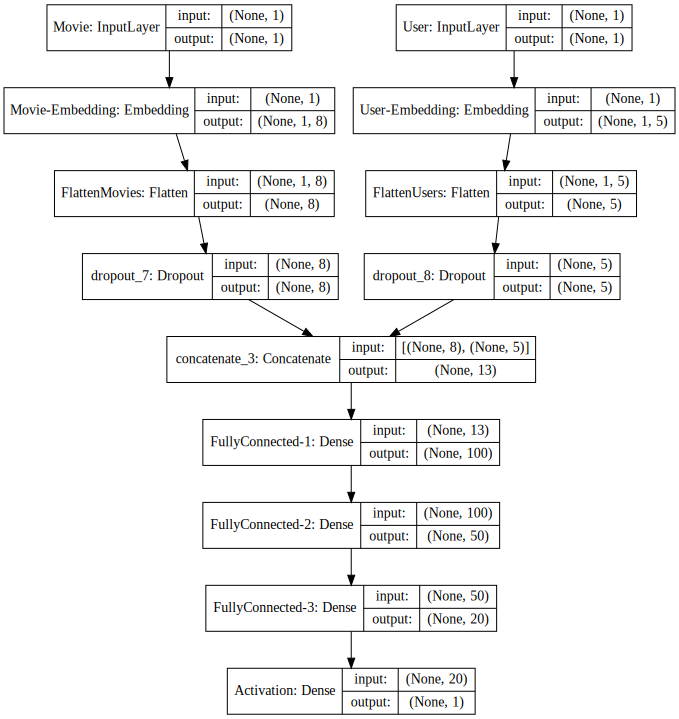

In [19]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.5)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.001),loss= 'mean_squared_error')

#visualize model
SVG(model_to_dot(model,  show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Text(0, 0.5, 'Train Error')

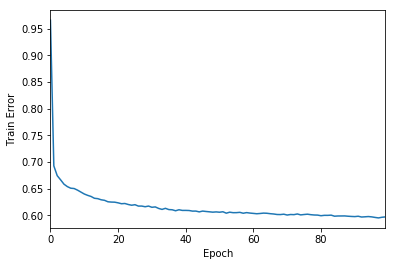

In [12]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [13]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating

print("MAE:",mean_absolute_error(y_true,y_hat))
print("RMSE:",sqrt(mean_squared_error(y_true, y_hat)))

MAE: 0.6580454582782171
RMSE: 0.88710439128024


# Adding Genre data to the network
<br>
Create one-hot encoding for Genres


In [14]:
ratings['genres'] = ratings.genres.apply(lambda x: x.split("|"))
movies['genres'] = movies.genres.apply(lambda x: x.split("|"))

one_hot = MultiLabelBinarizer()
one_hot.fit(movies['genres'])
genres = one_hot.transform(ratings['genres'])
print(ratings.head())
print(genres.shape)

   userId  movieId  rating             title  \
0       0        0     4.0  Toy Story (1995)   
1       4        0     4.0  Toy Story (1995)   
2       6        0     4.5  Toy Story (1995)   
3      14        0     2.5  Toy Story (1995)   
4      16        0     4.5  Toy Story (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1  [Adventure, Animation, Children, Comedy, Fantasy]  
2  [Adventure, Animation, Children, Comedy, Fantasy]  
3  [Adventure, Animation, Children, Comedy, Fantasy]  
4  [Adventure, Animation, Children, Comedy, Fantasy]  
(100836, 20)


The total genres that the encoder used were 20. <br>
With this way we generate a (n_movies, 20) matrix having ones on genres that a specific movie has.

Split the dataset taking into consideration that we also need to split the genres array

In [15]:
train, test ,genres_train, genres_test = train_test_split(ratings,genres, test_size=0.05)

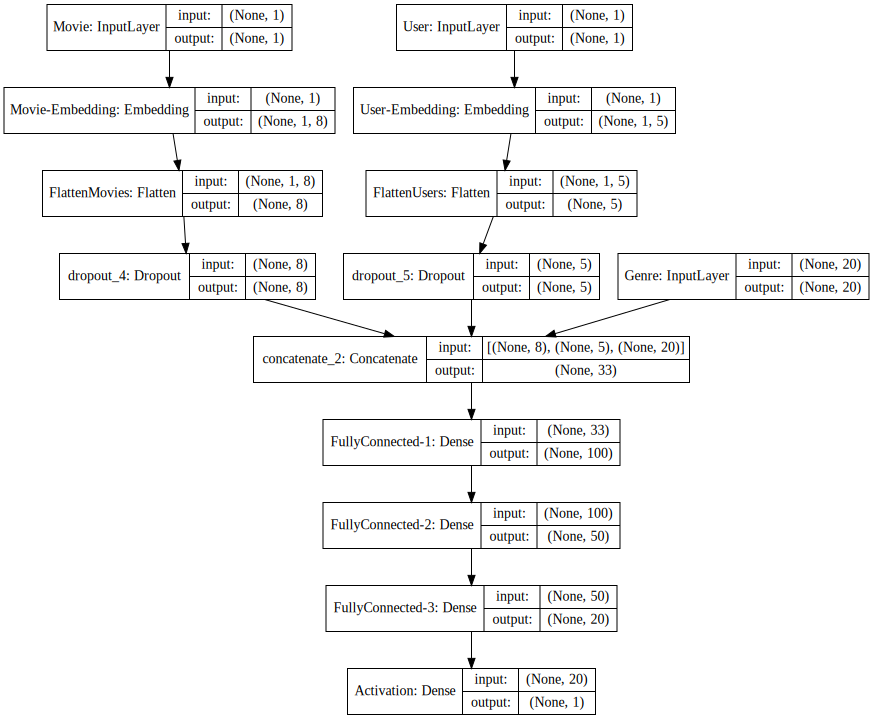

In [16]:
# Keras model
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.5)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

genre_input = keras.layers.Input(shape=[20],name='Genre')
# genre_vec = keras.layers.Flatten(name='FlattenGenre')(keras.layers.Embedding(20, 7 ,name='Genre-Embedding')(genre_input))


concat = keras.layers.concatenate([movie_vec, user_vec,genre_input])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
model = keras.Model([user_input, movie_input,genre_input], result)
model.compile(optimizer=Adam(lr=0.001),loss= 'mean_squared_error')

#visualize model
SVG(model_to_dot(model,  show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Text(0, 0.5, 'Train Error')

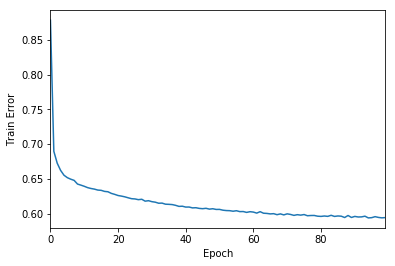

In [17]:
history = model.fit([train['userId'], train['movieId'],genres_train], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [18]:
y_hat = model.predict([test.userId, test.movieId,genres_test])
y_true = test.rating

print("MAE:",mean_absolute_error(y_true,y_hat))
print("RMSE:",sqrt(mean_squared_error(y_true, y_hat)))

MAE: 0.666730809902114
RMSE: 0.8909131757332502
